Praca domowa 2 (8 pkt.)
Termin: 07.04.2021 23:59

Dla wybranego modelu przygotuj knitr/jupyter notebook w formacie html lub pdf rozwiązując poniższe punkty. Pracę domową należy zgłosić przez Pull Request na GitHub w folderze PraceDomowe/PracaDomowa2/Nazwisko_Imię.

    Dla wybranej obserwacji ze zbioru danych wylicz predykcję modelu.
    Dla wybranej obserwacji z punktu 1., wylicz dekompozycję predykcji modelu używając LIME (pakiety w R: live, lime, localModel, iml, pakiety w Python: lime, dalex).
    Porównaj dekompozycję LIME dla różnych obserwacji w zbiorze. Jak stabilne są otrzymane wyjaśnienia?
    Skomentuj poszczególne wyniki uzyskane w powyższych punktach.
    Dla wybranej obserwacji porównaj wyjaśnienie LIME wyjaśnieniem BreakDown lub SHAP
    W pracy domowej oceniane przede wszystkim będą wnioski z otrzymanych analiz. Kod potrzebny do reprudokowalności wyników również proszę załączyć.

Prace domowe należy zgłaszać przez Pull Request o tytule Nazwisko Imię PD2. Wszystkie pliki związane z pracą domową proszę o umieszczenie w folderze Nazwisko_Imię.

In [1]:
suppressWarnings(suppressMessages(library(OpenML)))
suppressWarnings(suppressMessages(library(mlr)))
suppressWarnings(suppressMessages(library(pROC)))
suppressWarnings(suppressMessages(library(plyr)))
suppressWarnings(suppressMessages(library(DALEX)))
suppressWarnings(suppressMessages(library(DALEXtra)))
suppressWarnings(suppressMessages(library("lime")))

set.seed(6)

In [2]:
def <- suppressWarnings(suppressMessages(getOMLDataSet(data.id = 37)))
def <- def$data
def$class <- mapvalues(def$class, 
          from=c("tested_positive","tested_negative"), 
          to=c(1,0))
head(def)

,preg,plas,pres,skin,insu,mass,pedi,age,class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0


In [3]:
m <- sample(1:nrow(def), 0.7*nrow(def))
train <- def[m,]
test <- def[-m,]

In [4]:
classif_task <- makeClassifTask(id = "lvr", data = train, target = "class")

classif_lrn <- makeLearner("classif.svm", predict.type = "prob")

In [5]:
model <- train(classif_lrn, classif_task)

# Dla wybranej obserwacji ze zbioru danych wylicz predykcję modelu.

In [6]:
r <- test[sample(1:nrow(test), 1),]
r

,preg,plas,pres,skin,insu,mass,pedi,age,class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
547,4,131,68,21,166,33.1,0.16,28,0


In [7]:
pred_r <- predict(model, newdata = r)$data$prob.0
pred_r

[1] 0.8192554

Maszyna wektorów nośnych dosyć dobrze przewiduje rekord

# Dla wybranej obserwacji z punktu 1., wylicz dekompozycję predykcji modelu używając LIME

In [8]:
explainer <- DALEX::explain(model = model,
                     data = def[,-9],
                     y = as.numeric(as.character(def$class)))

Preparation of a new explainer is initiated
  -> model label       :  WrappedModel  (  default  )
  -> data              :  768  rows  8  cols 
  -> target variable   :  768  values 
  -> predict function  :  yhat.WrappedModel  will be used (  default  )
  -> predicted values  :  numerical, min =  0.04241866 , mean =  0.6503798 , max =  0.9428413  
  -> model_info        :  package mlr , ver. 2.19.0 , task classification (  default  ) 
  -> residual function :  difference between y and yhat (  default  )
  -> residuals         :  numerical, min =  -0.9428413 , mean =  -0.3014215 , max =  0.9575813  
  A new explainer has been created!  


In [9]:
model_type.dalex_explainer <- DALEXtra::model_type.dalex_explainer
predict_model.dalex_explainer <- DALEXtra::predict_model.dalex_explainer

In [10]:
lime_svm <- predict_surrogate(explainer = explainer, 
                                     new_observation = r[, -9], 
                                     n_features = 3, 
                                     n_permutations = 1000,
                                     type = "lime")

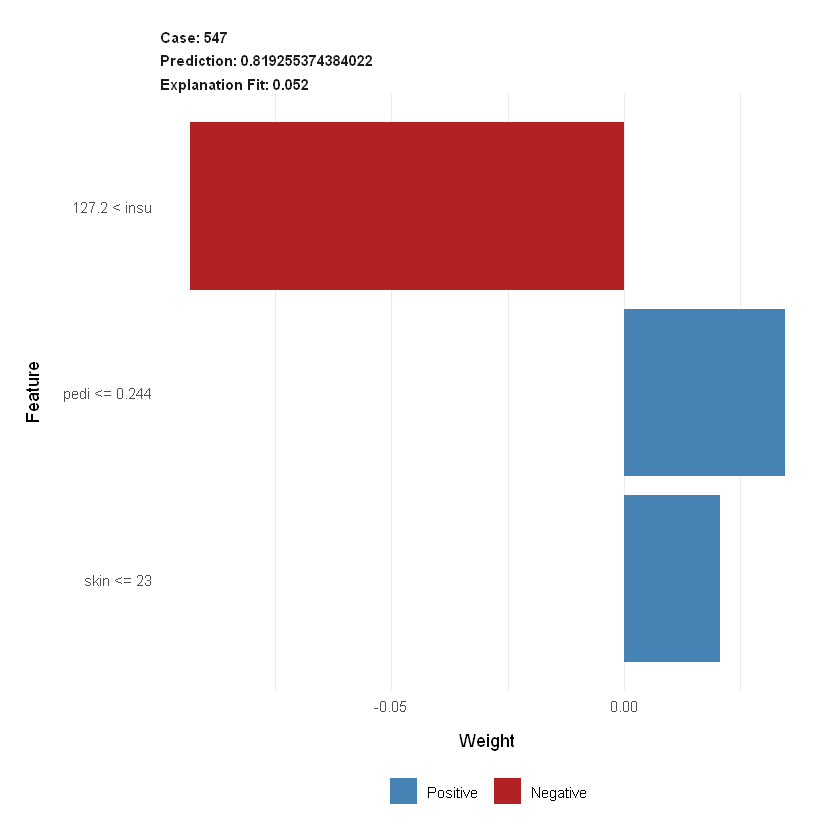

In [11]:
plot(lime_svm)

Kożystając z metody LIME doszliśmy do wniosku, że dla tego konkretnego przypadku wartość zmiennej *insu* powyżej 127,2 miała największy wpływ na prawdopodobieństwo wystąpienia cukrzycy. Zaraz potem, największy wpływ mają zmienne *pedi* niewiększa od 0,244 i *skin* niewiększa od 23

# Porównaj dekompozycję LIME dla różnych obserwacji w zbiorze. Jak stabilne są otrzymane wyjaśnienia?

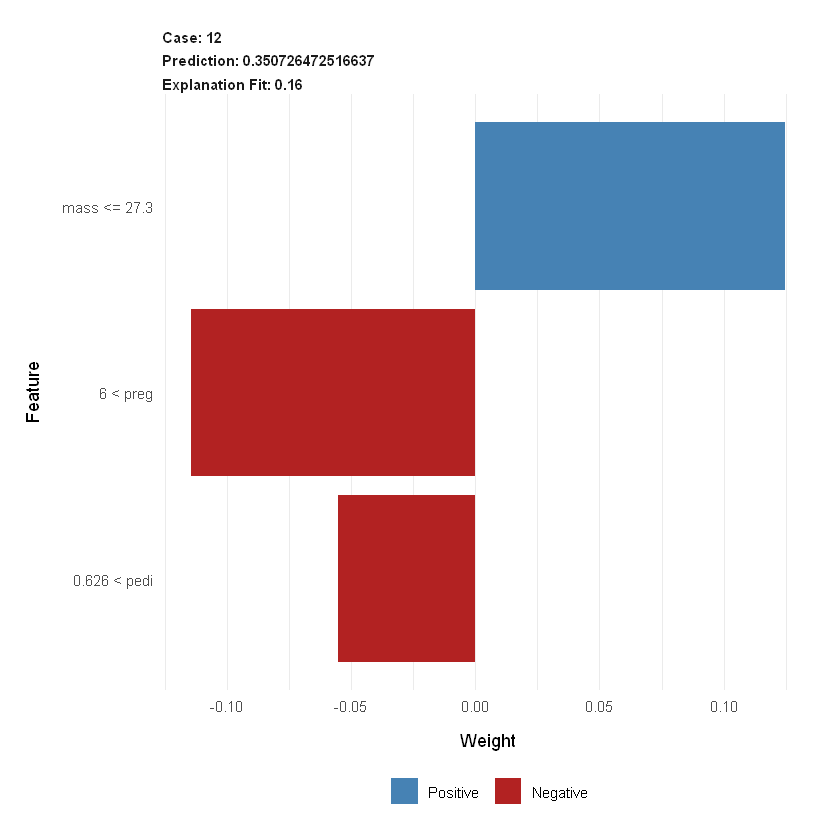

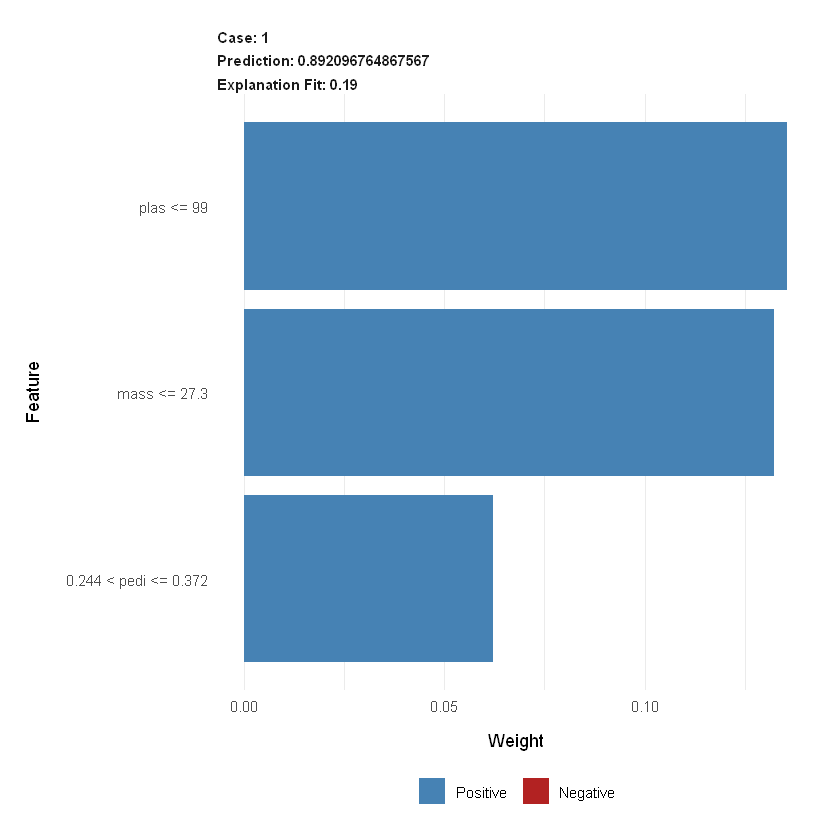

In [12]:
lime_svm_1 <- predict_surrogate(explainer = explainer, 
                                     new_observation = test[3, -9], 
                                     n_features = 3, 
                                     n_permutations = 1000,
                                     type = "lime")
lime_svm_2 <- predict_surrogate(explainer = explainer, 
                                     new_observation = test[1, -9], 
                                     n_features = 3, 
                                     n_permutations = 1000,
                                     type = "lime")
plot(lime_svm_1)
plot(lime_svm_2)

Można zauważyć, że dla różnych obserwacji LIME zwraca różne najistotniejsze zmienne. Zmienne zgodne w obu przypadkach *mass <= 27.3* mają bardzo zbliżony wpływ na predykcję, co jednak nie musi zachodzić w ogólności. Warto też zwrócic uwagę na bardzo słabe dopasowanie.

# Dla wybranej obserwacji porównaj wyjaśnienie LIME wyjaśnieniem BreakDown lub SHAP

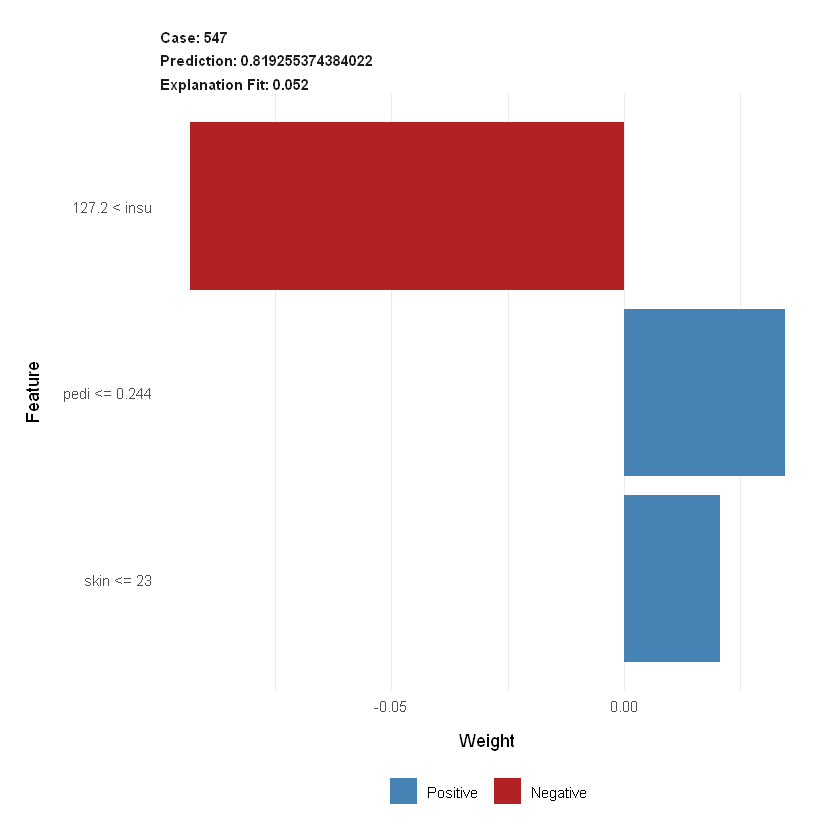

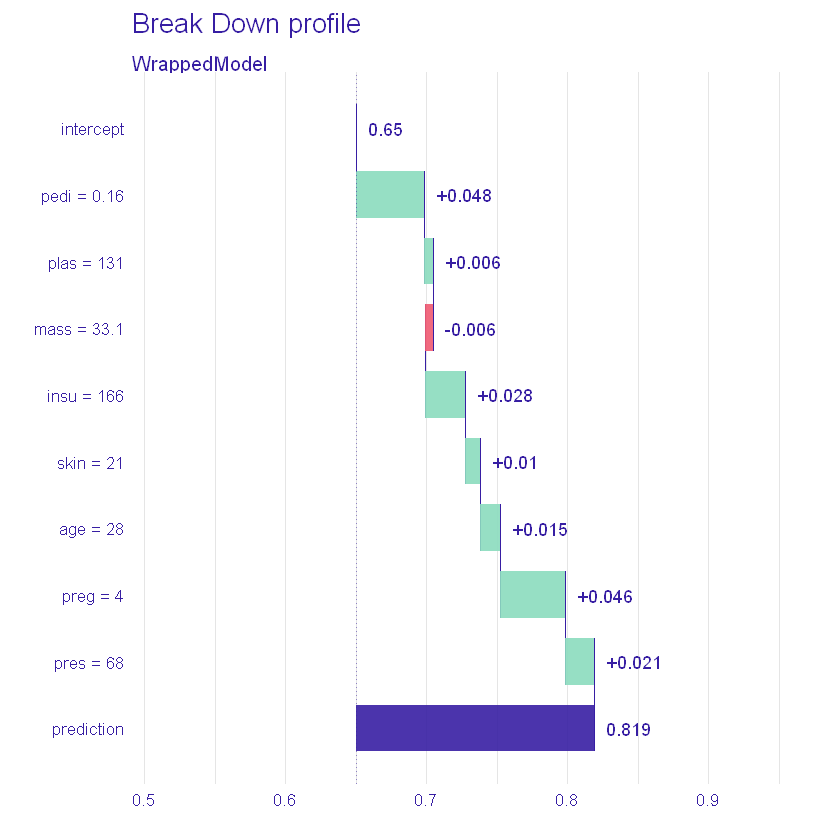

In [13]:
plot(lime_svm)
pp_SVM <- predict_parts(explainer, new_observation = r, type = "break_down")
plot(pp_SVM)

Wyjaśnienia LIME oraz Breakdown mogą prowadzić do istotnie różnych wniosków. Widać to najbardziej przy zmiennej *insu*. LIME twierdzi, że wartość tej zmiennej wpływa znacznie negatywnie na wynik (~ -0,1), a Breakdown, przeciwnie (+0,03). Różnie się również kolejność zmiennych ze względu na ich istotność. Dla Breakdown były to *pedi, preg i insu* a dla LIME *insu, pedi i skin*